The following project was inspired by a paper published by the Fiete Lab earlier this year, pertaining to online spatial navigation with the aid of BVCs, grid cells, and fragmentation events. A basic implementation of the program below goes as follows:

Offline spatial navigation relies on knowing every aspect of the environment a user is navigating, such that we can deduce the predictability of each position in the environment. We then segment the environment into distinct regions based on data.

Online navigation simply involves calculating the predictability of an environment by navigating it in real time. We form an understanding of how rooms connect to each other depending on the route taken by the user.

Let's tackle offline navigation first.

Step 1: Initialize some variables we'll need down the line.

In [1]:
import pygame
import pickle as pkl
import numpy as np

# Specificies how big our environment is, screen-wise

SIDE_LEN = 500

# Specifies how big the painting tool is

CURSOR_RAD = 5

# Colors

WHITE = (255, 255, 255)
BLACK = (0, 0, 0)
RED = (255, 0, 0)
BLUE = (0, 0, 255)
GREEN = (0, 255, 0)

environment = np.ones((SIDE_LEN, SIDE_LEN))

screen = pygame.display.set_mode((SIDE_LEN, SIDE_LEN))
screen.fill(WHITE)

running, pressed = True, False

print("Variables initialized!")

pygame 2.1.2 (SDL 2.0.18, Python 3.9.7)
Hello from the pygame community. https://www.pygame.org/contribute.html
Variables initialized!


Step 2: Initialize some functions we'll need in the next step.

In [2]:
# This pickles and saves a file containing all info pertaining to the virtual environment

def save_environment(environment):
    map_file = open('environment', 'ab')
    pkl.dump(environment, map_file)
    map_file.close()

# Clamps value at a maximum and minumum value

def clamp(val, max_val):
    return min(max(val, 0), max_val)
    
# Handle a key press event by declaring the state of pressed, and update screen with new values as required

def handle_key_press(screen, event, environment, running, pressed):
    if event.type == pygame.QUIT:
        save_environment(environment)
        running = False
    if event.type == pygame.KEYDOWN:
        save_environment(environment)
        running = False
        [x, y] = pygame.mouse.get_pos()
        return environment, running, pressed
    if event.type == pygame.MOUSEBUTTONDOWN:
        pressed = True
    if event.type == pygame.MOUSEBUTTONUP:
        pressed = False
    if event.type == pygame.MOUSEMOTION and pressed:
         environment = update_screen(screen, environment)
    return environment, running, pressed

# Add values to the array of the environment and update the screen
                
def update_screen(screen, environment):
    [x, y] = pygame.mouse.get_pos()
    for i in range(-1*CURSOR_RAD, CURSOR_RAD + 1):
        for j in range(-1*CURSOR_RAD, CURSOR_RAD + 1):
            environment[clamp(y+i, SIDE_LEN - 1)][clamp(x+j, SIDE_LEN - 1)] = 0
            pygame.draw.rect(screen, BLACK, (x-CURSOR_RAD, y-CURSOR_RAD, CURSOR_RAD*2, CURSOR_RAD*2))
    return environment

print("Functions initialized!")

Functions initialized!


Step 3: Run the code to create the environment. Simply press down on your keypad and drag to draw the environment -- we will be "digging" out the map, which means everything in white will be a wall/boundary. Once finished, click any key to exit.

In [3]:
# Main program

def draw_map(environment, running, pressed):
    while running:
        for event in pygame.event.get():
            environment, running, pressed = handle_key_press(screen, event, environment, running, pressed)
        pygame.display.flip()
    pygame.quit()
    return environment

environment = draw_map(environment, running, pressed)

print("Finished environment!")

Finished environment!


Now, we will use the environment we produced in step 1 in navigation tasks. Let's start by just showing the data using matplotlib.

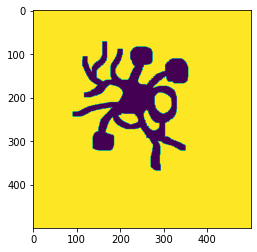

Environment displayed


In [4]:
import matplotlib.pyplot as plt

plt.imshow(environment)
plt.show()

print("Environment displayed")

Let's go back to pygame for a second and address the key component of our offline navigation: the sensory map.

Step 1: Initialize some variables we'll need to make the sensory map.

In [5]:
# Reset some stuff

running = True
pygame.init()

screen = pygame.display.set_mode((SIDE_LEN, SIDE_LEN))
screen.fill(WHITE)

# Incremental value of tracker variable used to create spatial map

dt = 0.5

# Number of ticks in the spatial map generated

TICKS = 8

# Generated list of directions

THETAS = np.linspace(-1*np.pi, np.pi, TICKS)

# Multiply the number of ticks outward from a point by the appropriate element here, and you get the cartesian conversion

X_COMP = np.cos(THETAS)
Y_COMP = np.sin(THETAS)

print("Variables initialized!")

Variables initialized!


Step 2: Initialize the functions we'll need. 

In [6]:
# Determines if the tracker used to generate the spatial map is about to exit bounds

def in_bounds(val):
    return val < SIDE_LEN and val >= 0

# Generates sensory map at a reference point (x, y)

def generate_sensory_map(x, y, environment):
    sensory_map = np.zeros((TICKS))
    for tick in range(TICKS):
        map_in_bounds = True
        edge_reached = False
        # Increment tracker until boundary reached
        t = 0
        while map_in_bounds and not edge_reached:
            map_in_bounds = (in_bounds(x + t*X_COMP[tick]) and in_bounds(y - t*Y_COMP[tick]))
            edge_reached = environment[int(y - t*Y_COMP[tick])][int(x + t*X_COMP[tick])] == 1
            t += dt
        sensory_map[tick] = t
    return sensory_map

# Draws out the environment after having stored it

def draw_online_environment(screen, environment):
    screen.fill(WHITE)
    for row in range(environment.shape[0]):
        for col in range(environment.shape[1]):
            if environment[row][col] == 0:
                pygame.draw.rect(screen, BLACK, (col, row, 1, 1))

# Draw mini sensory map

def draw_sensory_map(x, y, screen, environment):
    draw_online_environment(screen, environment)
    sensory_map = generate_sensory_map(x, y, environment)
    pygame.draw.circle(screen, RED, (x, y), 5)
    for tick in range(TICKS):
        pygame.draw.circle(screen, GREEN, (int(sensory_map[tick]*X_COMP[tick] + x), int(y - sensory_map[tick]*Y_COMP[tick])), 5)

# Handle a key press event by declaring the state of pressed, and update screen with new values as required

def handle_key_press(screen, event, running):
    if event.type == pygame.QUIT:
        running = False
    if event.type == pygame.KEYDOWN:
        [x, y] = pygame.mouse.get_pos()
        draw_sensory_map(x, y, screen, environment)
    return running

print("Functions initialized!")

Functions initialized!


Step 3: Run the demo, which gives an intuitive description of exactly how sensory maps are made in this program. Click any key in any black area, and observe the green and red dots generated: the green dots compose the sensory map, while the red dot represents the position at which the sensory map was taken. Quit pygame to exit.

In [8]:
# Main program

def construct_sensory_maps(environment, running):
    draw_online_environment(screen, environment)

    while running:
        for event in pygame.event.get():
            running = handle_key_press(screen, event, running)
        pygame.display.flip()
    pygame.quit()

construct_sensory_maps(environment, running)

print("Finished demo!")

Finished demo!


Those sensory maps we made will have to be made for every position on our map. For this next section, we will have the program construct sensory maps for each 5x5 section of the environment that we'll use later on.

Step 1: Initialize/reset some variables.

In [9]:
# For efficiency's sake, we choose ever tenth point (row, col) to construct a sensory map

STEP = 5

# Number of ticks in the spatial map generated

TICKS = 512

# Generated list of directions

THETAS = np.linspace(-1*np.pi, np.pi, TICKS)

# Multiply the number of ticks outward from a point by the appropriate element here, and you get the cartesian conversion

X_COMP = np.cos(THETAS)
Y_COMP = np.sin(THETAS)

print("Variables initialized!")

Variables initialized!


Step 2: Initialize the functions and run the program, too. This'll take 2 minutes.

In [10]:
# Save sensory maps

def save_all_sensory_maps(all_sensory_maps):
    all_sensory_maps_file = open('all_sensory_maps', 'ab')
    pkl.dump(all_sensory_maps, all_sensory_maps_file)
    all_sensory_maps_file.close()

# Iterates through all rows and columns of a map and generates a map at each respective point

def generate_sensory_map_for_all_points(environment):
    all_sensory_maps = np.zeros((int(SIDE_LEN/STEP), int(SIDE_LEN/STEP), TICKS))
    for i in range(0, SIDE_LEN, STEP):
        row = int(i/STEP)
        for j in range(0, SIDE_LEN, STEP):
            col = int(j/STEP)
            if environment[i][j] != 1:
                sensory_map = generate_sensory_map(j, i, environment)
                all_sensory_maps[row][col] = sensory_map
    save_all_sensory_maps(all_sensory_maps)
    return all_sensory_maps
    
all_sensory_maps = generate_sensory_map_for_all_points(environment)
save_all_sensory_maps(all_sensory_maps)

print("Sensory maps created!")

Sensory maps created!


Now things will get more intense for our program -- we are going to be taking each sensory map generated at each position, and compare them to adjacent maps. Doing this will let us calculate each position's relative "surprise" value, which shall then be recorded in a "surprise map."

Step 1: Quickly initialize some variables that will be useful.

In [11]:
# The fixed euclidean distance at which surprisal is collected relative to the reference point

RADIUS = 2

# Because we are making a circle out of pixels, we add an error to ensure a ring of points is collected to compare

ERROR = 1

print("Variables initialized!")

Variables initialized!


Step 2: Initialize all the functions needed to make the surprise map. Construct the surprise map.

NOTE: This will take a little bit of time. I will perhaps work to optimize the program down the road -- but for now, feel free to simply run the cell below and take ~7 minutes to peruse Reddit or PubMed or whatever strikes you fancy :)

In [12]:
# Save surprise map

def save_surprise_map(surprise_map):
    surprise_map_file = open('surprise_map', 'ab')
    pkl.dump(surprise_map, surprise_map_file)
    surprise_map_file.close()

# Given a cartesian point, find an approximate in polar coordinate theta value, where theta is a member of THETAS

def get_round_theta_index(x, y):
    if x > 0:
        theta = np.arctan(y/x)
    elif x == 0 and y > 0:
        theta = np.pi/2
    elif x == 0 and y < 0:
        theta = -1*np.pi/2
    elif y > 0:
        theta = -1*np.arctan(y/x)  + np.pi/2
    elif y < 0:
        theta = np.arctan(y/x)  - np.pi
    elif y == 0:
        theta = np.pi
    else:
        theta = 0
    round_theta_index = int( clamp( np.round( (np.round( TICKS*theta/np.pi ) + TICKS )/2 ), max_val=TICKS - 1 ) )
    return round_theta_index

# In order to compare maps that are offset from each other, you must convert to cartesian coordinates,
# Then you must center both at the origin, then convert both back into polar coordinates

def offset_and_shift_map_at_origin(offset_x, offset_y, map_at_origin):
    # Initialize the sensory map that shall be shifted to approximate the current "investigating map" at the offset point
    map_at_origin_shifted_to_fit_investigating_map = np.zeros((TICKS))
    # For point in the shifted map, find an approximation in terms of valid values r, theta
    for tick in range(TICKS):
        x_point = map_at_origin[tick]*X_COMP[tick] + offset_x
        y_point = map_at_origin[tick]*Y_COMP[tick] - offset_y
        # Theta values are discretized
        #So converting cartesian points to polar coordinates means we have to adjust them to fit the discrete theta values we outlined in constants.py
        round_theta_index = get_round_theta_index(x_point, y_point)
        rad = np.sqrt(x_point**2 + y_point**2)
        map_at_origin_shifted_to_fit_investigating_map[round_theta_index] = np.round(rad, 1)
    return map_at_origin_shifted_to_fit_investigating_map

def find_error_between_maps(offset_x, offset_y, map_at_origin, investigating_map, offset_or_gaussian="offset"):
    map_at_origin_shifted_to_fit_investigating_map = offset_and_shift_map_at_origin(offset_x, offset_y, map_at_origin)
    
    # This is a container for filling the unfilled polar coordinates at the acceptable theta ticks
    new_rad_storage = np.zeros(TICKS)
    
    for tick in range(TICKS):
        rad = map_at_origin_shifted_to_fit_investigating_map[tick]
        # If one of the slots at a value theta is empty, we really ought to fill it
        if tick > 0 and tick < TICKS and rad == 0:
            # Consatantly expand the range at which you look to find the nearest points to make a mean from
            num_valids = np.argwhere(map_at_origin_shifted_to_fit_investigating_map[tick - 1: tick + 2] > 0).size
            counter = 0
            while num_valids == 0:
                counter += 1
                num_valids = np.argwhere(map_at_origin_shifted_to_fit_investigating_map[tick - (2 + counter): tick + (3 + counter)] > 0).size
            # Make a new radius that's basically an approximation from other surrounding values	
            new_rad = np.sum(map_at_origin_shifted_to_fit_investigating_map[tick - (2 + counter): tick + (3 + counter)])/num_valids
            new_rad_storage[tick] = new_rad

    for tick in range(TICKS):
        if new_rad_storage[tick] != 0:
            map_at_origin_shifted_to_fit_investigating_map[tick] = np.round(new_rad_storage[tick], 1)

    # Choose whether to evaluate "surprisal" by how unpredictable the radius of the sensory map at a certain value might be,
    # or rather by how much the two maps differ from each other
    if offset_or_gaussian == "offset":
        error = np.linalg.norm(map_at_origin_shifted_to_fit_investigating_map - investigating_map)
    else:
        error = calculate_error_by_gaussian(map_at_origin_shifted_to_fit_investigating_map, investigating_map)
    return error

# Find points at a fixed radius away from the reference. Generate the average surprisal by summing all surprises

def generate_surprise_for_one_point(row, col, all_sensory_maps):
    surprise_map = []
    for y in range(clamp(row - RADIUS, all_sensory_maps.shape[0]), clamp(row + RADIUS, all_sensory_maps.shape[0])):
        for x in range(clamp(col - RADIUS, all_sensory_maps.shape[1]), clamp(col + RADIUS, all_sensory_maps.shape[1])):
            # Test if current offset point lies on the circle at RADIUS radius away from row, col
            edge = np.abs(np.sqrt((col - x)**2 + (row - y)**2) - RADIUS) < ERROR
            if np.sum(all_sensory_maps[y][x]) > 0: #and edge:
                offset_x = (col - x)*STEP
                offset_y = (row - y)*STEP
                surprise = find_error_between_maps(offset_x, offset_y, all_sensory_maps[row][col], all_sensory_maps[y][x])
                surprise_map.append(surprise)
                
    if len(surprise_map) > 0:
        return sum(surprise_map) / len(surprise_map)
    else:
        return 0

# For every point where sensory maps were recorded, find the surprisal at that point

def generate_surprise_map(all_sensory_maps):
    surprise_map = np.zeros(all_sensory_maps.shape[:2])
    for row in range(surprise_map.shape[0]):
        for col in range(surprise_map.shape[1]):
            if np.sum(all_sensory_maps[row][col]) != 0:
                surprise_for_one_point = generate_surprise_for_one_point(row, col, all_sensory_maps)
                surprise_map[row][col] = surprise_for_one_point
    return surprise_map

surprise_map = generate_surprise_map(all_sensory_maps)
save_surprise_map(surprise_map)

print("Surprise map created!")

Surprise map created!


Graph the surprise map in order to see which regions of the environment are relatively intense -- that is, have a high rate of surprisal -- versus areas that aren't. Data shall be plotted at a heatmap.

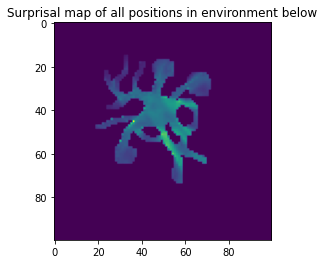

In [13]:
# Plot the surprise map in matplotlib
def present_surprise_map(surprise_map):
    plt.title("Surprisal map of all positions in environment below")
    plt.imshow(surprise_map)
    plt.show()
    
present_surprise_map(surprise_map)

One last thing! Let's think about making an isomap to represent some of this data.

Step 1: This process has a lot of moving parts. So we'll take it in shifts. First up, let's initialize the distance matrix function, which takes in all of our points and outputs the distance between them. Then, we'll make the whole isomap by "weighting" the points by their distances apart on the distance matrix.

In [14]:
from sklearn.manifold import MDS
from sklearn.cluster import DBSCAN
from random import randint

#DBSCAN param

EPS = 5

# Cutoff for what we define as a room, in terms of how many points are included. Clusters of less than this point number are ignored

MIN_POINTS_FOR_CLUSTER_TO_BE_CONSIDERED_REGION = 20

print("Variables initialized!")

Variables initialized!


Step 2: Now let's initialize all the functions required.

In [15]:
# Calculate the distance matrix matrix off all the points with surprisal scores

def make_distance_matrix(surprise_map):
    new_surprise_map = []
    for i in range(surprise_map.shape[0]):
        for j in range(surprise_map.shape[1]):
            if surprise_map[i][j] != 0:
                new_surprise_map.append({"surprise": surprise_map[i][j], "coord":  (i, j)}) 
    surprise_map = np.array(new_surprise_map)
    distance_matrix = np.zeros((surprise_map.size, surprise_map.size))
    for i in range(surprise_map.size):
        for j in range(surprise_map.size):
            if surprise_map[i]["surprise"] != surprise_map[j]["surprise"]:
                # We multiply the magnitude of the distance vectore by the prximity of the two points being compared
                distance_matrix[i][j] = np.log(np.abs(surprise_map[i]["surprise"] - surprise_map[j]["surprise"]))*np.sqrt((surprise_map[i]["coord"][0] - surprise_map[j]["coord"][0])**2 +(surprise_map[i]["coord"][1] - surprise_map[j]["coord"][1])**2)
            else:
                distance_matrix[i][j] = 0
    return distance_matrix

# Create isomap from distance matrix of all points. Apply dbscan clustering

def make_isomap(distance_matrix):
    # Create isomap
    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=6)
    results = mds.fit(distance_matrix)
    coords = results.embedding_
    # Cluster resulting points
    clustering = DBSCAN(eps=EPS, min_samples=2).fit(coords)
    labels = clustering.labels_
    return coords, labels

distance_matrix = make_distance_matrix(surprise_map)
coords, labels = make_isomap(distance_matrix)

print("Isomap created!")

Isomap created!


Now for the slightly tedious part. In this implementation of the isomap, we have a lot of strange data clusters that don't really go with anything. It would be good to clean them out for the sake of testing -- let's initialize those functions now.

In [16]:
# Go through all clusters and cut out the ones with less than the minimum required points to be considered a unique region

def determine_significance_of_each_region(labels):
	each_room_total_point_number = {}
	for fixed_label in labels:
		cluster_point_count = 0
		for label in labels:
			if label == fixed_label:
				cluster_point_count += 1
		each_room_total_point_number[str(fixed_label)] = cluster_point_count
	return each_room_total_point_number
		
# Determine the number of regions with a significant number of points (ie: actual rooms)

def determine_number_of_significant_regions(each_room_total_point_number):
	unique_region_count = 0
	for key in each_room_total_point_number.keys():
		point_number = each_room_total_point_number[key]
		if point_number > MIN_POINTS_FOR_CLUSTER_TO_BE_CONSIDERED_REGION:
			unique_region_count += 1
	return unique_region_count

# Don't bother adding the points that belong to the regions we don't care about

def clean_coords_of_nonsignificant_regions(coords, labels, each_room_total_point_number):
	coords = np.array([coords[i] for i in range(coords.shape[0]) if each_room_total_point_number[str(labels[i])] > MIN_POINTS_FOR_CLUSTER_TO_BE_CONSIDERED_REGION])
	return coords

print("Functions initialized!")

Functions initialized!


Nothing left to do but graph the thing. Let's do that now!

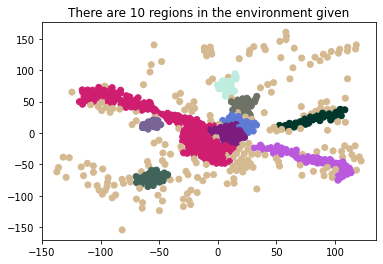

In [17]:
# Plot isomap in matplotlib

def present_isomap(coords, labels, show_clustering):
	if show_clustering:
		each_room_total_point_number = determine_significance_of_each_region(labels)
		unique_region_count = determine_number_of_significant_regions(each_room_total_point_number)
		coords = clean_coords_of_nonsignificant_regions(coords, labels, each_room_total_point_number)
		colors = [(randint(0, 255)/255, randint(0, 255)/255, randint(0, 255)/255) for _ in range(labels.size + 1)]
		colors_for_each_coord = [colors[labels[i]] for i in range(labels.size) if each_room_total_point_number[str(labels[i])] > MIN_POINTS_FOR_CLUSTER_TO_BE_CONSIDERED_REGION]
		plt.title("There are " + str(unique_region_count) + " regions in the environment given")
	else:
		colors_for_each_coord = [(100, 100, 255) for _ in range(coords.shape[0])]
		plt.title("Approximate isomap of environment below")
	plt.scatter(
	    coords[:, 0], coords[:, 1], marker = 'o', color=colors_for_each_coord
	)
	plt.show()
    
present_isomap(coords, labels, show_clustering=True)

The isomap above, most likely, is imperfect -- some parameters might have to be retuned based on the environment in question. This portion of the program should be fixed down the road.

For now, though, that concludes the portion of our offline navigation. Let's move onto online navigation!

Step 1: Initialize some variables for our boundary vector cells.

In [18]:
#Stuff for BVCs

BVC_PER_ROW, BVC_PER_COL = 100, 100

# Our environment is 500x500 pixels. We will have each 5x5 region region belong to a distinct BVC

PIXEL_PER_BVC = int(SIDE_LEN/BVC_PER_ROW)

# Other physical properties of the environment

ENVIRONMENT_DIMEN = 5 	# meters
METERS_TO_PIXELS = int(SIDE_LEN/ENVIRONMENT_DIMEN)

# Some constants to describe how far and how often BVCs exist in terms of distance from the subject

BVC_RADIUS = int(SIDE_LEN/2)
BVC_RAD_STEP = 2
BVC_TICK_STEP = 4

print("Variables initialized!")

Variables initialized!


Step 2: Initialize the functions our BVCs utilized when stimulated -- that is, when a boundary exists at their particular radius and theta.

In [20]:
# Integrate all values of r and theta across each BVC
def get_total_freq(sensory_map, r, theta, theta_for_each_r):
	freq_theta = freq_at_theta(theta, theta_for_each_r, sigma_angle=0.01)
	freq_r = 1
	#freq_r = freq_at_r(r, r)
	return freq_theta*freq_r

# Get the frequency contribution to a BVC at each distinct theta
def freq_at_theta(theta, phi, sigma_angle):
	theta_component = np.exp((-1*(theta - phi)**2)/sigma_angle)
	return theta_component

# Get the frequency contribution to a BVC at each distinct r
def freq_at_r(r, d):
	sigma_rad = d
	r_component = np.exp(-1*sigma_rad*(d - r)**2)
	return r_component

# Make a cartesian array of BVCs and find the frequencies of each one given the current bounds in terms of r, theta
def update_bvc(x, y, environment):
	bvc_cartesian_array = np.zeros((BVC_PER_ROW, BVC_PER_COL))
	sensory_map = generate_sensory_map(x, y, environment)
	min_rad, max_rad = 0, int(np.max(sensory_map)) #int(np.min(sensory_map)), int(np.max(sensory_map))
	# Range cannot handle floats so we iterate by whole numbers and divide
	for tick in range(TICKS):
		theta = THETAS[tick]
		r = sensory_map[tick]
		for tick_for_each_r in range(0, TICKS, BVC_TICK_STEP):
			theta_for_each_r = THETAS[tick_for_each_r]
			bvc_x = int(x + r*X_COMP[tick_for_each_r])
			bvc_x = int((bvc_x - bvc_x%PIXEL_PER_BVC)/PIXEL_PER_BVC)

			bvc_y = int(y - r*Y_COMP[tick_for_each_r])
			bvc_y = int((bvc_y - bvc_y%PIXEL_PER_BVC)/PIXEL_PER_BVC)
			try:
				bvc_cartesian_array[bvc_y][bvc_x] = get_total_freq(sensory_map, r, theta, theta_for_each_r)
			except:
				continue
	return bvc_cartesian_array

print("Functions initialized!")

Functions initialized!


BVC activity is stored and accessed in two different ways: STM (Short Term Memory), and LTM (Long Term Memory). This implementation differs slightly from the paper for the time being, but I eventually aim to correlate STM/LTM states to grid cell activity.

Step 1: STM Initialization.

In [21]:
# Constants for STM

STM_RANGE = 10

# Roll back the stm to shift it

def roll_back_stm(stm):
	rolled_stm = np.zeros(stm.shape)
	for slot in range(1, STM_RANGE):
		rolled_stm[slot - 1] = stm[slot]
	rolled_stm[-1] = stm[0]
	return rolled_stm

# Adds a new memory to the STM, or replaces an old one

def add_memory_to_stm(bvc_array, stm, curr_stm_size):
	if curr_stm_size < STM_RANGE:
		stm[curr_stm_size] = bvc_array.flatten()
		curr_stm_size += 1
	else:
		stm = roll_back_stm(stm)
		stm[-1] = bvc_array.flatten()
	return stm, curr_stm_size

# Apply a gaussian convolution to the STM

def create_mov_avg_from_stm(stm, curr_stm_size):
	mov_avg = np.zeros((BVC_PER_ROW*BVC_PER_COL))
	memory_slots = np.arange(0, curr_stm_size)
	weights = np.exp(-1*(memory_slots - int(curr_stm_size/2))**2)
	for slot in range(0, curr_stm_size):
		mov_avg += weights[slot]*stm[slot]
	return mov_avg

# Present the averaged BVC array STM

def present_stm_avg(stm_avg):
	plt.title("BVC memory at the current position")
	plt.imshow(stm_avg.reshape((BVC_PER_ROW, BVC_PER_COL)))
	plt.show()
    
print("STM initialized!")

STM initialized!


Step 2: LTM Initialization

In [22]:
# Constants for LTM

MAX_MEMORIES = 10

# Adds a new memory to the LTM if space exists

def add_memory_to_ltm(bvc_array, ltm, curr_ltm_size):
	if curr_ltm_size < MAX_MEMORIES:
		ltm[curr_ltm_size] = bvc_array.flatten()
		curr_ltm_size += 1
	else:
		ltm[randint(0, MAX_MEMORIES - 1)] = bvc_array.flatten()
	return ltm, curr_ltm_size

print("LTM initialized!")

LTM initialized!


Step 3: Let's tie STM and LTM together with the code required to make judgements on how "surprise-y" a location is compared to what a user has previously seen.

In [23]:
# Get a prediction score by comparing current STM and current BVC activity

def create_pred_score(stm_map, bvc_array):
	stm_map = stm_map.flatten()
	bvc_array = bvc_array.flatten()
	if np.max(stm_map) != 0:
		stm_map /= np.linalg.norm(stm_map)
	if np.max(bvc_array) != 0:
		bvc_array /= np.linalg.norm(bvc_array)
	return np.dot(stm_map, bvc_array.T)

# Basically just takes the dot product of the current bvc values and all memories in the ltm, finding the closest approximation

def check_if_map_matches_any_current_entries(bvc_array, ltm):
	normalized_bvc_array = bvc_array.flatten() / np.linalg.norm(bvc_array.flatten())
	for memory in ltm:
		normalized_memory = memory
		if np.max(normalized_memory) != 0:
			normalized_memory = memory / np.linalg.norm(memory)
		if np.dot(normalized_memory, normalized_bvc_array.T) >= CERTAINTY_SCORE_THAT_MEMORIES_MATCH:
			return True
	return False

# Evaluates the surprisal level given the change from the previous position to the new one

def make_judgement_on_location(x, y, environment, stm, ltm, curr_stm_size, curr_ltm_size):
	bvc_array = update_bvc(x, y, environment)
	stm_avg = create_mov_avg_from_stm(stm, curr_stm_size)
	pred_score = create_pred_score(stm_avg, bvc_array)
	stm, curr_stm_size = add_memory_to_stm(bvc_array, stm, curr_stm_size)
	if pred_score < PRED_THRESHHOLD:
		was_successful = check_if_map_matches_any_current_entries(bvc_array, ltm)
		if was_successful:
			print("I've seen this before")
		else:
			ltm, curr_ltm_size = add_memory_to_ltm(bvc_array, ltm, curr_ltm_size)
			print("New room!")
	present_stm_avg(stm_avg)
	print("Current surprisal score: " + str(pred_score))
	return environment, stm, ltm, curr_stm_size, curr_ltm_size

print("Functions initialized!")

Functions initialized!


Step 4: Now let's go back and initialize some variables for our pygame program. We're almost done!!

In [24]:
# If a user hasn't clicked to add a new point to the path in online navigation, we just use this as a stand-in

INVALID_COORD = -1000

# Decided based on my own measurements. 0.9 is a li'l high

PRED_THRESHHOLD = 0.5

# How to compare the current observation and a memory in ltm, to see if you've been in the same room before

CERTAINTY_SCORE_THAT_MEMORIES_MATCH = 0.8

print("Variables initialized!")

Variables initialized!


Step 5: Now the functions, and we run it! For reference: you must click a key to set down a new position on the environment, on lay them out in a path. Progress through the environment slowly (key word: as slow as possible) for the best results! Quit to finish.

New room!


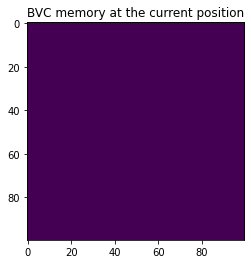

Current surprisal score: 0.0


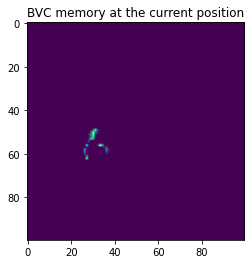

Current surprisal score: 0.8250557139741252


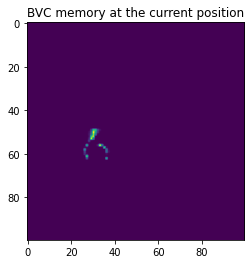

Current surprisal score: 0.8592403121353405


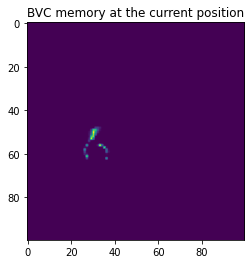

Current surprisal score: 0.7770017852042564


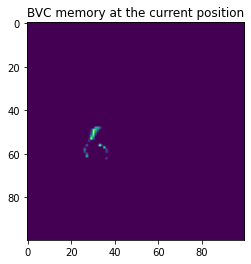

Current surprisal score: 0.7234776370027534


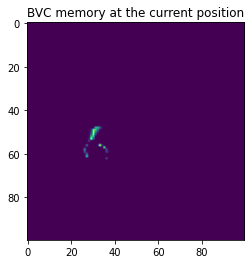

Current surprisal score: 0.6524350935356358


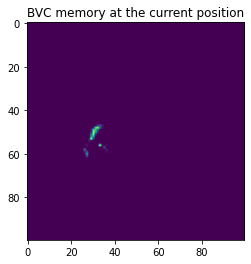

Current surprisal score: 0.6012957237339931


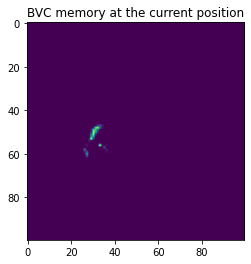

Current surprisal score: 0.5308376997072262
New room!


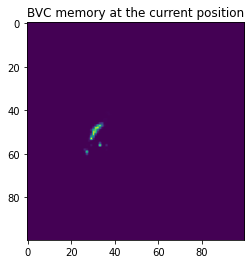

Current surprisal score: 0.4794642476952087
New room!


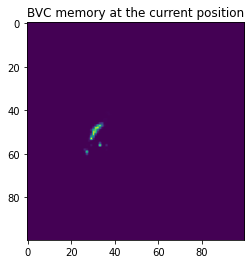

Current surprisal score: 0.37842317677782783
New room!


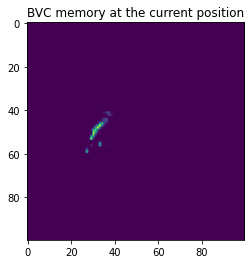

Current surprisal score: 0.34108055430723455
New room!


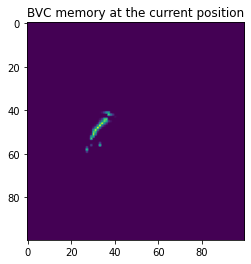

Current surprisal score: 0.3579821074505462
I've seen this before


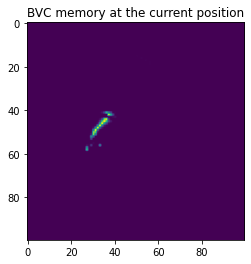

Current surprisal score: 0.37745498820519274
New room!


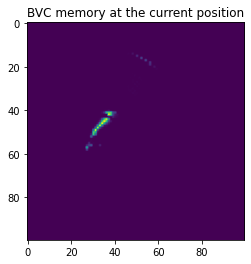

Current surprisal score: 0.3758666045715943
I've seen this before


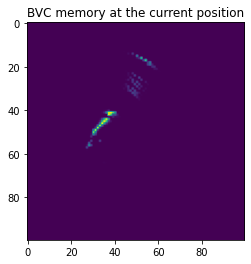

Current surprisal score: 0.48993189422907435


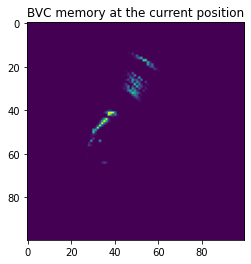

Current surprisal score: 0.5405908050595999


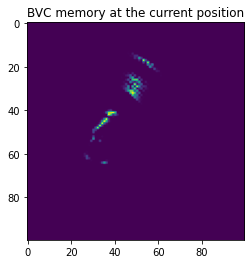

Current surprisal score: 0.5507081712838136


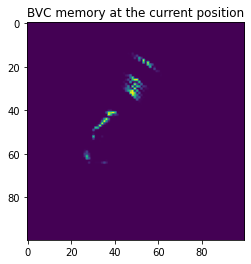

Current surprisal score: 0.5258451603228729


In [25]:
# If a key was pressed, add the position to the online path. Otherwise, just return invalid data

def handle_online_key_press(screen, event, environment, all_points, running):
    if event.type == pygame.QUIT:
        running = False
    if event.type == pygame.KEYDOWN:
        [x, y] = pygame.mouse.get_pos()
        if environment[y][x] == 0:
            update_online_screen(screen, all_points, x, y)
            all_points.append([x, y])
            return x, y, running, all_points
        else:
            return INVALID_COORD, INVALID_COORD, running, all_points
    return INVALID_COORD, INVALID_COORD, running, all_points

# Add the points denoting the path

def update_online_screen(screen, all_points, x, y):
    if len(all_points) > 0:
        pygame.draw.line(screen, GREEN, all_points[-1], [x, y])
    pygame.draw.circle(screen, RED, [x, y], 2)
    return x, y

# Main function. Every tick of the program, check to see if the user has added onto the path. If so, update the state of the program

def explore_environment(environment, stm, ltm, curr_stm_size, curr_ltm_size):
    all_points = []
    pygame.init()
    screen = pygame.display.set_mode((SIDE_LEN, SIDE_LEN))
    screen.fill(WHITE)
    running, pressed = True, False
    draw_online_environment(screen, environment)
    while running:
        for event in pygame.event.get():
           x, y, running, all_points = handle_online_key_press(screen, event, environment, all_points, running)
           if (x, y) != (INVALID_COORD, INVALID_COORD):
            environment, stm, ltm, curr_stm_size, curr_ltm_size = make_judgement_on_location(x, y, environment, stm, ltm, curr_stm_size, curr_ltm_size)
        pygame.display.flip()
    pygame.quit()
    
# Initializes all variables, runs online navigation guided by user in pygame

def run_navigation(random_or_guided="guided"):
	# Initialize the current sizes of the LTM and STM
	curr_ltm_size = 0
	curr_stm_size = 0
	# Initialize LTM and STM
	stm = np.zeros((STM_RANGE, BVC_PER_ROW**2))
	ltm = np.zeros((MAX_MEMORIES, BVC_PER_ROW**2))
	# Run program in pygame
	if random_or_guided == "guided":
		explore_environment(environment, stm, ltm, curr_stm_size, curr_ltm_size)
	else:
		print("Unable to randomly generate path.")
        
run_navigation(random_or_guided="guided")

And, that's about it! We've now done all steps of the program introduced up to date, with the exception of grid cells. We'll go over the implementation now, even if the cells won't be used in the above code for the time being.

Step 1: Declare the Grid Cell class.

In [26]:
class GridCell:
    def __init__(self, lambda_m=0.5, theta=0):
        self.lambda_m = lambda_m*METERS_TO_PIXELS
        self.theta = theta
        self.translate_x = randint(0, int(self.lambda_m/2))
        self.translate_y = randint(0, int(self.lambda_m/2))
        self.firing_map = np.zeros((SIDE_LEN, SIDE_LEN))
        self.rad = self.lambda_m		# Completely arbitrary. Will fix later. Should map to lattice scale
        self.diam = 2*self.rad
        self.init_centers()

    # Optional smoothing. I don't use this
    
    def smoothing(self, val):
        return np.exp(0.3*(val+1.5))

    # Sum the three consinusoidal waves to get the hexagonal pattern, scaled. thetas not yet implemented
    
    def get_magnitude_of_firing_map_at_point(self, x, y, center):
        center_x, center_y = center[0], center[1]
        displacement_mag = np.sqrt(((x - (center_x)) **2 + (y - (center_y))**2))
        self.firing_map[clamp(y, self.firing_map.shape[0] - 1)][clamp(x, self.firing_map.shape[1] - 1)] += np.exp(-1*(displacement_mag**2)/self.lambda_m)
        theta_base = np.pi/3
        for k in range(-2, 1):
            theta_k = theta_base*k
            offset_x = int(np.cos(theta_k)*self.rad)
            offset_y = int(np.sin(theta_k)*self.rad)
            displacement_mag = np.sqrt(((x - (center_x + offset_x)) **2 + (y - (center_y + offset_y))**2))

            firing_map_y = y + offset_y
            firing_map_x = x + offset_x

            #if firing_map_y >= 0 and firing_map_y < SIDE_LEN and firing_map_x >= 0 and firing_map_x < SIDE_LEN:
            firing_map_val = self.firing_map[clamp(firing_map_y, self.firing_map.shape[0] - 1)][clamp(firing_map_x, self.firing_map.shape[1] - 1)]
            self.firing_map[clamp(firing_map_y, self.firing_map.shape[0] - 1)][clamp(firing_map_x, self.firing_map.shape[1] - 1)] = clamp(firing_map_val + np.exp(-1*(displacement_mag**2)/self.lambda_m), 1)

    # At a particular center, calulate the value of the grid cell firing map
    
    def get_firing_map_at_center(self, center):
        for y in range(0, SIDE_LEN):
            for x in range(0, SIDE_LEN):
                self.get_magnitude_of_firing_map_at_point(x, y, center)

    # Create the equally spaced centers of the grid cells
    
    def init_centers(self):
        self.centers = []
        y_step = int(2*self.diam*np.sin(np.pi/3))
        x_step = int(2*self.diam)
        for y in range(0, SIDE_LEN + y_step - self.translate_y, y_step):
            for x in range(0, SIDE_LEN - self.translate_x, x_step):
                self.centers.append([x + self.translate_x, y + self.translate_y])

    # For each center in the grid cell's centers, add the center to the firing map
    
    def construct_firing_map(self):
        for center in self.centers:
            self.get_firing_map_at_center(center)
            
print("Grid cell class initialized!")

Grid cell class initialized!


Step 2: Initialize some functions that use the grid cells. Run those functions.

NOTE: The program, as it runs now, takes a pretty long time to run. The first grid cell takes the longest, and each successive one takes exponentially less time.

*
Grid Cell 1 created
*
*******************
*
Grid Cell 2 created
*
*******************
*
Grid Cell 3 created
*
*******************
*
Grid Cell 4 created
*
*******************
*
Grid Cell 5 created
*
*******************
*
Grid Cell 6 created
*
*******************


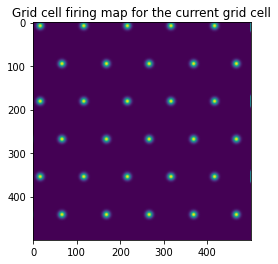

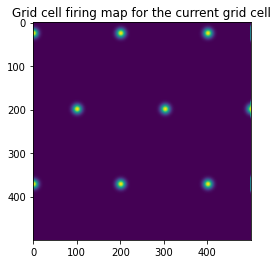

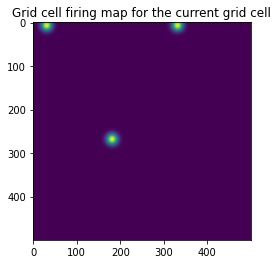

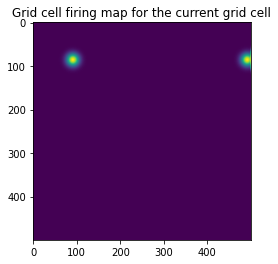

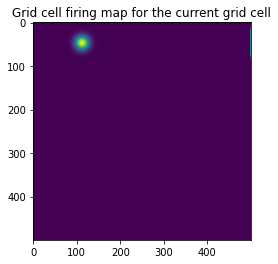

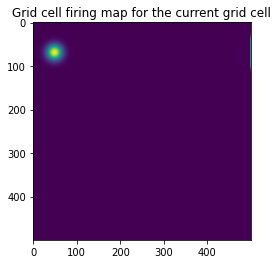

In [104]:
# Constants for physical environment grid cell conversion

NUM_GRID_CELLS = 6

# Save grid cells

def save_grid_cells(grid_cells):
    grid_cell_file = open('grid_cells', 'ab')
    pkl.dump(grid_cells, grid_cell_file)
    grid_cell_file.close()

# Announce a new grid cell was created

def announce_new_grid_cell(index):
    print("*")
    print("Grid Cell " + str(index+1) + " created")
    print("*")
    print("*******************")

# Self explanatory. Makes the grid cells

def create_all_grid_cells():
    grid_cells = []
    for i in range(NUM_GRID_CELLS):
        new_cell = GridCell(lambda_m=0.5*(i+1))
        new_cell.construct_firing_map()
        grid_cells.append(new_cell)
        announce_new_grid_cell(i)
    return grid_cells

# Graphs the firing maps

def show_all_firing_maps(grid_cells):
    for cell in grid_cells:
        plt.title("Grid cell firing map for the current grid cell")
        plt.imshow(cell.firing_map)
        plt.show()
        
grid_cells = create_all_grid_cells()
show_all_firing_maps(grid_cells)
save_grid_cells(grid_cells)

Realize that since the above is a demo, there remain some design kinks to work out before moving forward. The plan is to properly integrate grid cell activity into BVC, STM and LTM functionality, as specified in the paper.